In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn

## Load CIFAR10 Data

In [9]:

#define image transformation
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#define batch size
batch_size = 32

#Download and Load CIFAR10
trainset_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

#define training size, 20% of origional training data
train_size = int(0.2 * len(trainset_dataset))
test_size = len(trainset_dataset) - train_size

#split data into trainset and test_dataset, testdataset won't be use in this example and only use to store the remaining 80% of data from split
trainset, test_dataset = torch.utils.data.random_split(trainset_dataset, [train_size, test_size])

#load training data
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
#download and load test CIFAR10 data
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
#load test data
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)


# Define NN models

In [11]:

#Define MLP
class MLP(nn.Module):
    def __init__(self,layers,perceptrons):
        super().__init__()
        hidden_layers=[]
        #Dynamic hidden layer configuration
        for i in range(layers):
            hidden_layers.append(nn.Linear(perceptrons,perceptrons))
            hidden_layers.append(nn.Sigmoid())

        #Finalize and combining hidden layers into one single mlp
        self.NN = nn.Sequential(nn.Flatten(),
            nn.Linear(32 * 32 * 3, perceptrons),
            nn.Sigmoid(),
            *hidden_layers,
            nn.Linear(perceptrons, 10)
        )
       
    def forward(self, x):
        
        return self.NN(x)

#CNN1 configuration
class CNN1(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.NN = nn.Sequential(
            #apply first filter
            nn.Conv2d(3,64,3),
            nn.ReLU(),
            #apply second filter
            nn.Conv2d(64,64,3),
            nn.ReLU(),
            #flatten the data
            nn.Flatten(),
            #output result from convolution layers
            nn.Linear(28*28*64,512),
            nn.Sigmoid(),
            nn.Linear(512,512),
            nn.Sigmoid(),
            nn.Linear(512,10)
        )
        
    def forward(self, x):
        
        return self.NN(x)

class CNN2(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.NN = nn.Sequential(
            #apply first filter
            nn.Conv2d(3,64,3),
            nn.ReLU(),
            #apply Max pooling
            nn.MaxPool2d(2,2),
            #apply second filter
            nn.Conv2d(64,64,3),
            nn.ReLU(),
            #apply Max pooling
            nn.MaxPool2d(2,2),
            #flatten the output
            nn.Flatten(),
            #resulting output from convolution layers
            nn.Linear(6*6*64,512),
            nn.Sigmoid(),
            #apply dropout
            nn.Dropout(0.2),
            nn.Linear(512,512),
            nn.Sigmoid(),
            #apply dropout
            nn.Dropout(0.2),
            nn.Linear(512,10)
        )
        
    def forward(self, x):
        
        return self.NN(x)

## Check for CUDA

In [3]:

device = torch.device('cpu')

iscuda = torch.cuda.is_available()
if iscuda:
    device = torch.device('cuda')

## Training Loop

In [13]:
#training loop, take an optimizer, loss_function and epochs
def train_nn(NN,optimizer,loss_function,epochs):

  #define traing and test accuracy array to store accuracy calculation
  train_acc_arr = [0]
  test_acc_arr = [0]

  #iterate through predefined epochs
  for epoch in range(0, epochs): 
      
      #define current loss, correct pred and total pred
      current_loss = 0.0
      train_correct = 0
      train_total = 0
      test_correct = 0
      test_total = 0
     
      #loop through the train data
      for i, data in enumerate(trainloader, 0):
        
        inputs, targets = data
       
        #use cuda if availible
        if iscuda:
          NN.NN.to('cuda')
          inputs = inputs.cuda(non_blocking=True)
          targets = targets.cuda(non_blocking=True)

        #zero out gradient
        optimizer.zero_grad()
        
        #forward pass
        outputs = NN(inputs)

        #record accuracy
        _, y_pred = torch.max(outputs.data,1)
        train_correct += (y_pred == targets).sum().item()
        train_total += targets.size(0)
        
        #backward pass
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()
        current_loss += loss.item()
     
      #test accuracy with test data
      for i, data in enumerate(testloader, 0):
        
      
        inputs, targets = data
    
        if iscuda:
          NN.NN.to('cuda')
          inputs = inputs.cuda(non_blocking=True)
          targets = targets.cuda(non_blocking=True)
        
     
        outputs = NN(inputs)
        _, y_pred = torch.max(outputs.data,1)
        test_correct += (y_pred == targets).sum().item()
        test_total += targets.size(0)

      #calculate final accuracies
      train_accuracy = 100 * train_correct / train_total
      train_acc_arr.append(train_accuracy)
      
      test_accuracy = 100 * test_correct / test_total
      test_acc_arr.append(test_accuracy)
      #print train and test accuracy
      print('epoch:', epoch+1, 'train_accuracy', train_accuracy, 'test_accuracy', test_accuracy)

  
  #plot accuracies
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), constrained_layout = True)
  
 
  ax1.plot(train_acc_arr)
  ax1.set_title('Train Accruacy vs Epoch #')
  ax1.set(xlabel='Epoch', ylabel='Accuracy')
  ax2.plot(test_acc_arr)
  ax2.set_title('Test Accruacy vs Epoch #')
  ax2.set(xlabel='Epoch', ylabel='Accuracy')
  
  
    
    

## MLP Training

epoch: 1 train_accuracy 27.15 test_accuracy 34.13
epoch: 2 train_accuracy 35.91 test_accuracy 37.36
epoch: 3 train_accuracy 39.99 test_accuracy 38.76
epoch: 4 train_accuracy 44.04 test_accuracy 40.7
epoch: 5 train_accuracy 47.0 test_accuracy 42.4


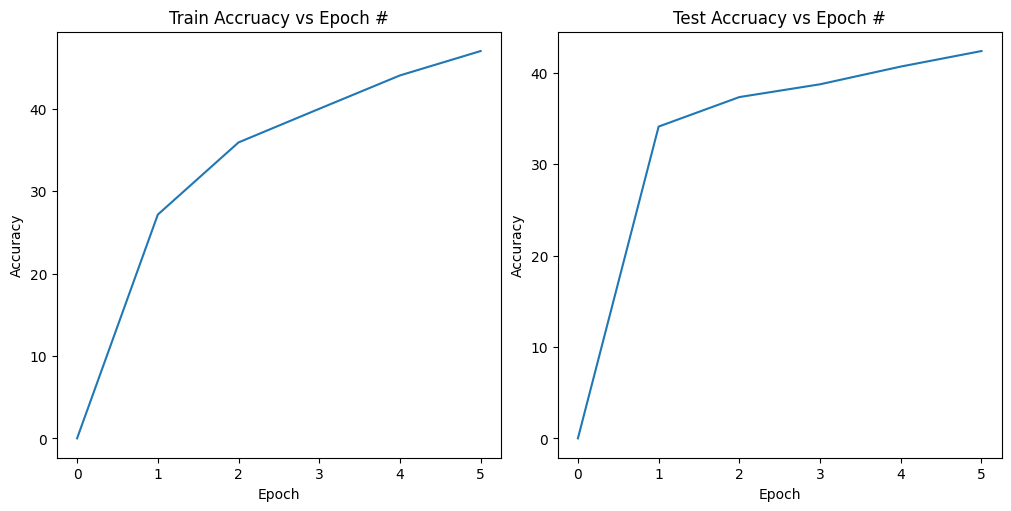

In [14]:
mlp = MLP(2,512)
#define loss function
loss_function = nn.CrossEntropyLoss()
#using Adam optimizer
optimizer_mlp = torch.optim.Adam(mlp.parameters(), lr=0.001)
#training for 5 epoch
train_nn(mlp,optimizer_mlp,loss_function,5)

## CNN1 Training

epoch: 1 train_accuracy 34.98 test_accuracy 45.14
epoch: 2 train_accuracy 50.35 test_accuracy 49.65
epoch: 3 train_accuracy 61.78 test_accuracy 54.49
epoch: 4 train_accuracy 74.68 test_accuracy 54.14
epoch: 5 train_accuracy 88.53 test_accuracy 53.9


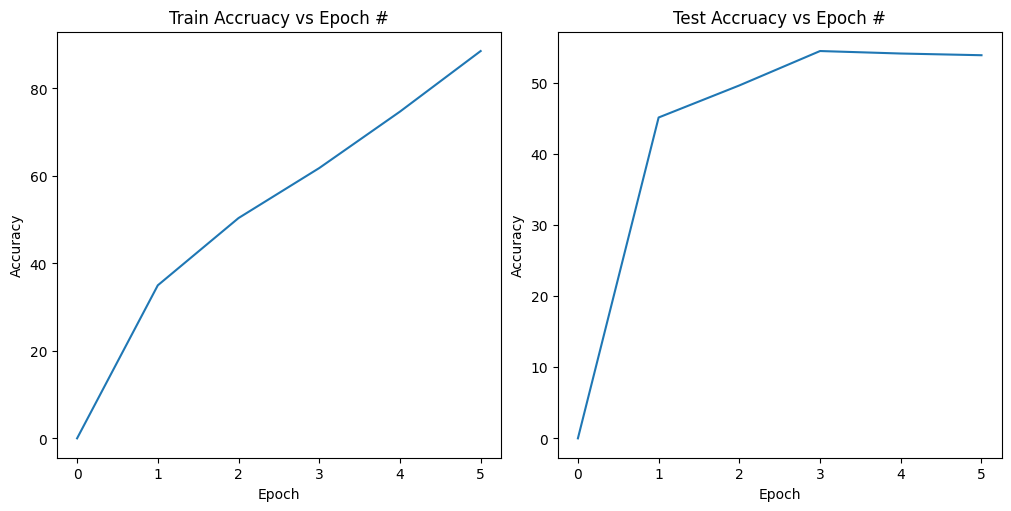

In [15]:
cnn1 = CNN1()
loss_function = nn.CrossEntropyLoss()
optimizer_cnn1 = torch.optim.Adam(cnn1.parameters(), lr=0.001)
#train for 5 epochs
train_nn(cnn1,optimizer_cnn1,loss_function,5)

CNN2 Training

epoch: 1 train_accuracy 31.03 test_accuracy 41.81
epoch: 2 train_accuracy 46.11 test_accuracy 49.03
epoch: 3 train_accuracy 53.08 test_accuracy 50.43
epoch: 4 train_accuracy 59.97 test_accuracy 55.95
epoch: 5 train_accuracy 65.74 test_accuracy 58.36


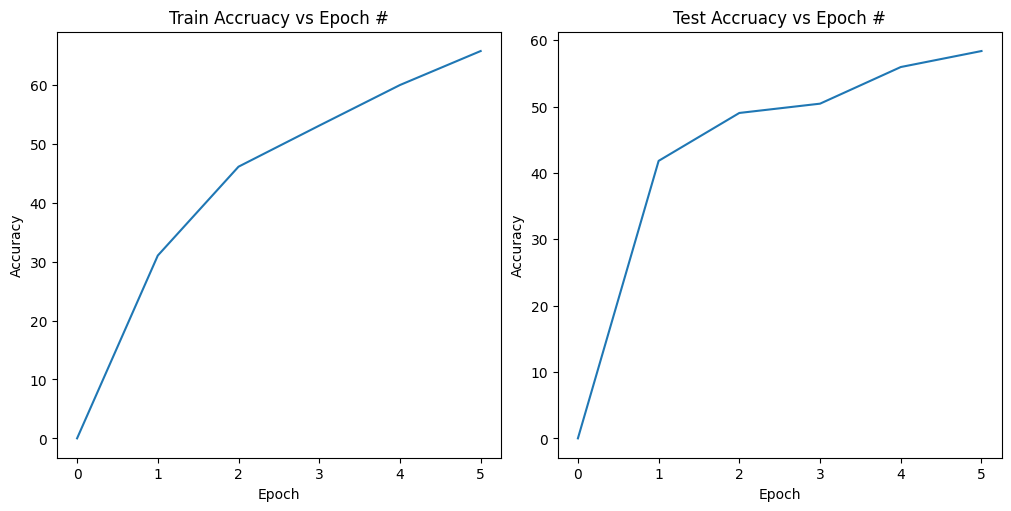

In [16]:
cnn2 = CNN2()
loss_function = nn.CrossEntropyLoss()
optimizer_cnn2 = torch.optim.Adam(cnn2.parameters(), lr=0.001)
#train for 5 epochs
train_nn(cnn2,optimizer_cnn2,loss_function,5)

# CNN1 and CNN2 training over 100 epochs

Training CNN1 for 100 epochs
epoch: 1 train_accuracy 33.12 test_accuracy 44.78
epoch: 2 train_accuracy 49.88 test_accuracy 48.45
epoch: 3 train_accuracy 59.75 test_accuracy 51.53
epoch: 4 train_accuracy 73.11 test_accuracy 54.27
epoch: 5 train_accuracy 87.11 test_accuracy 54.37
epoch: 6 train_accuracy 96.87 test_accuracy 55.6
epoch: 7 train_accuracy 99.43 test_accuracy 55.36
epoch: 8 train_accuracy 99.77 test_accuracy 56.03
epoch: 9 train_accuracy 99.9 test_accuracy 55.71
epoch: 10 train_accuracy 99.96 test_accuracy 55.83
epoch: 11 train_accuracy 99.88 test_accuracy 55.43
epoch: 12 train_accuracy 99.2 test_accuracy 50.84
epoch: 13 train_accuracy 93.3 test_accuracy 52.63
epoch: 14 train_accuracy 98.56 test_accuracy 54.14
epoch: 15 train_accuracy 99.64 test_accuracy 53.2
epoch: 16 train_accuracy 99.89 test_accuracy 53.05
epoch: 17 train_accuracy 99.96 test_accuracy 53.51
epoch: 18 train_accuracy 100.0 test_accuracy 53.93
epoch: 19 train_accuracy 100.0 test_accuracy 53.97
epoch: 20 train_

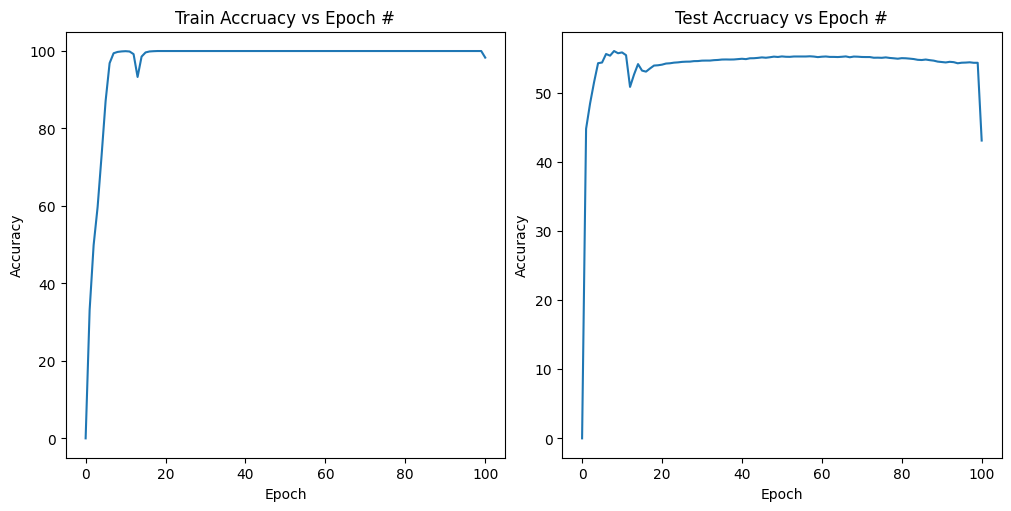

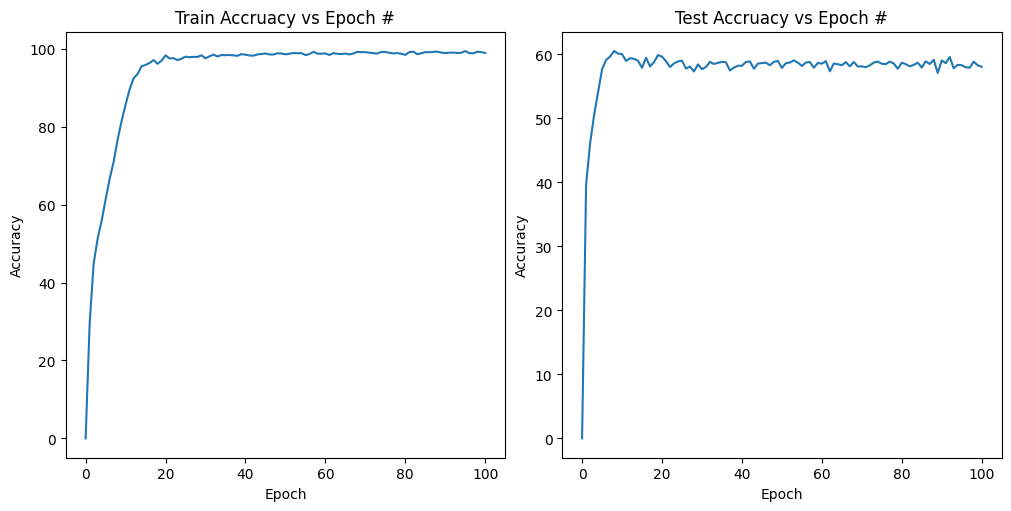

In [18]:
print("Training CNN1 for 100 epochs")
cnn1 = CNN1()
loss_function = nn.CrossEntropyLoss()
optimizer_cnn1 = torch.optim.Adam(cnn1.parameters(), lr=0.001)
#train for 100 epochs
train_nn(cnn1,optimizer_cnn1,loss_function,100)

print("Training CNN2 for 100 epochs")
cnn2 = CNN2()
loss_function = nn.CrossEntropyLoss()
optimizer_cnn2 = torch.optim.Adam(cnn2.parameters(), lr=0.001)
#train for 100 epochs
train_nn(cnn2,optimizer_cnn2,loss_function,100)

## Varying Number of Layers for MLP

Training MLP with  1  hidden layers
epoch: 1 train_accuracy 29.96 test_accuracy 37.38
epoch: 2 train_accuracy 38.25 test_accuracy 39.24
epoch: 3 train_accuracy 42.85 test_accuracy 40.63
epoch: 4 train_accuracy 47.57 test_accuracy 43.35
epoch: 5 train_accuracy 50.74 test_accuracy 43.17
Training MLP with  2  hidden layers
epoch: 1 train_accuracy 25.89 test_accuracy 33.21
epoch: 2 train_accuracy 35.61 test_accuracy 37.72
epoch: 3 train_accuracy 40.47 test_accuracy 37.0
epoch: 4 train_accuracy 42.73 test_accuracy 40.36
epoch: 5 train_accuracy 47.19 test_accuracy 41.14
Training MLP with  3  hidden layers
epoch: 1 train_accuracy 20.75 test_accuracy 21.72
epoch: 2 train_accuracy 28.79 test_accuracy 32.4
epoch: 3 train_accuracy 33.86 test_accuracy 32.88
epoch: 4 train_accuracy 37.84 test_accuracy 36.68
epoch: 5 train_accuracy 41.3 test_accuracy 38.75
Training MLP with  4  hidden layers
epoch: 1 train_accuracy 17.07 test_accuracy 19.03
epoch: 2 train_accuracy 22.47 test_accuracy 26.14
epoch: 3 

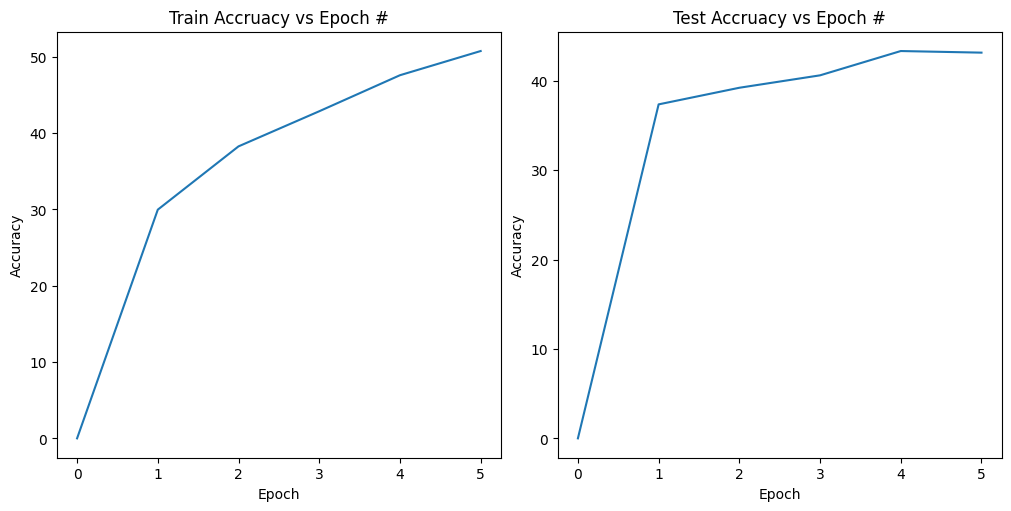

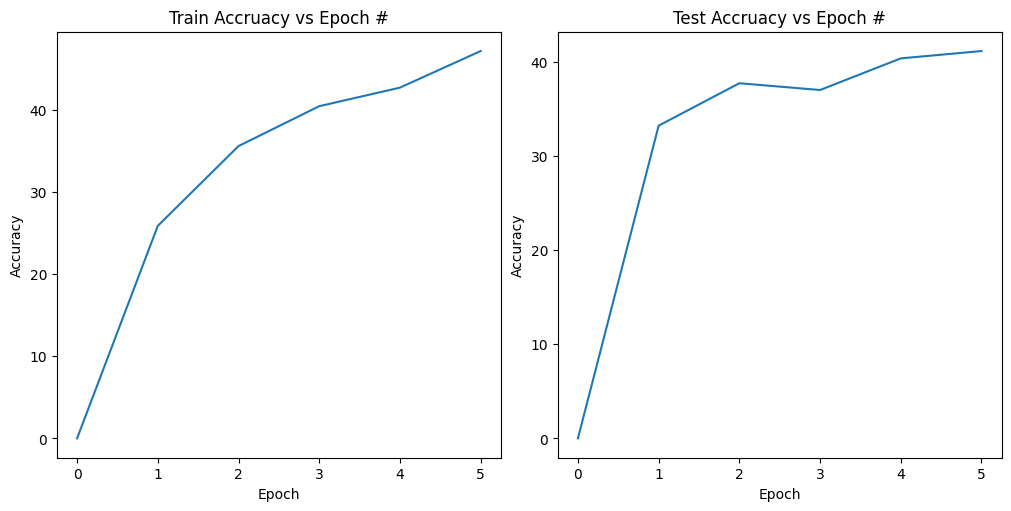

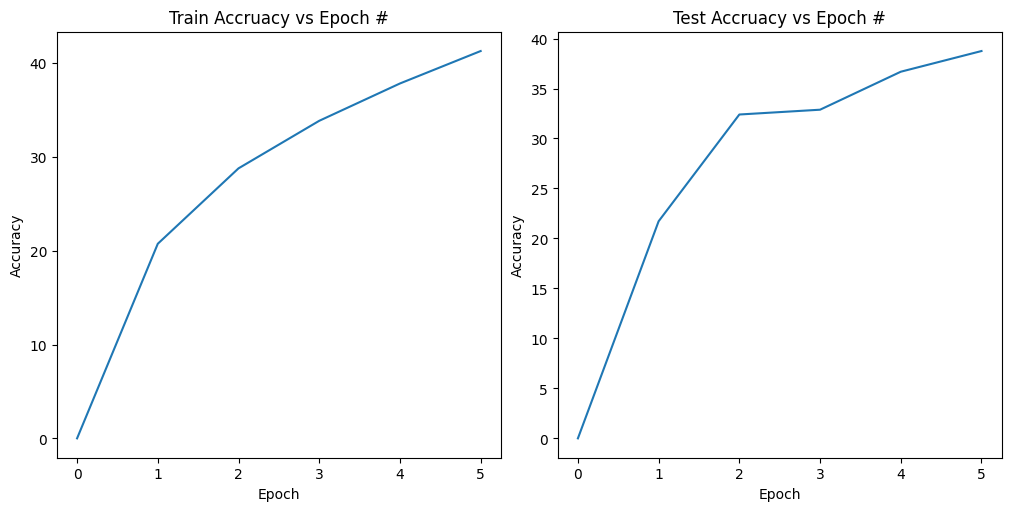

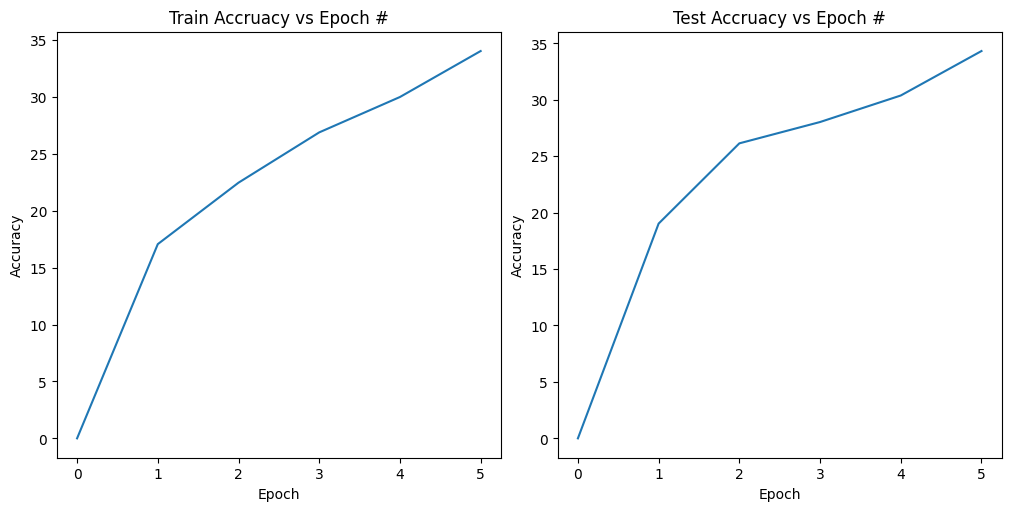

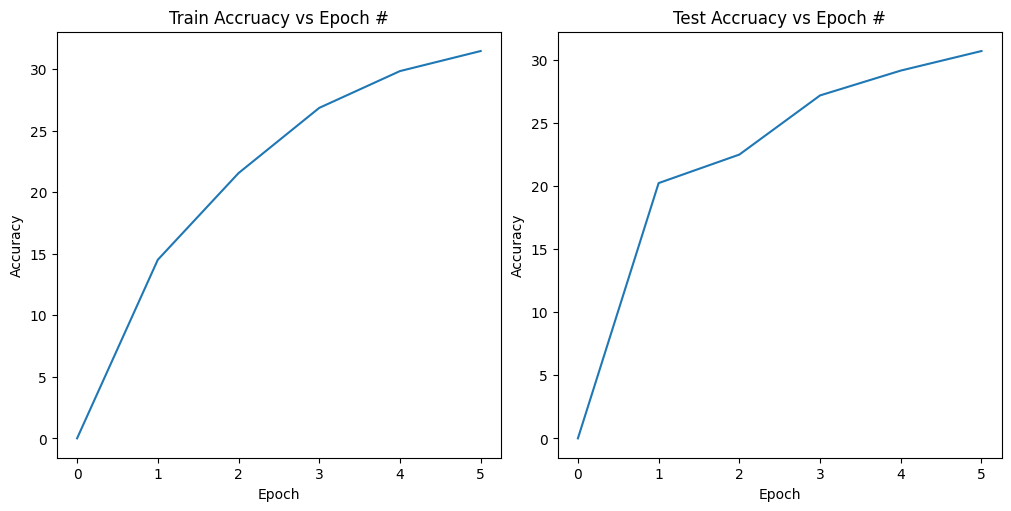

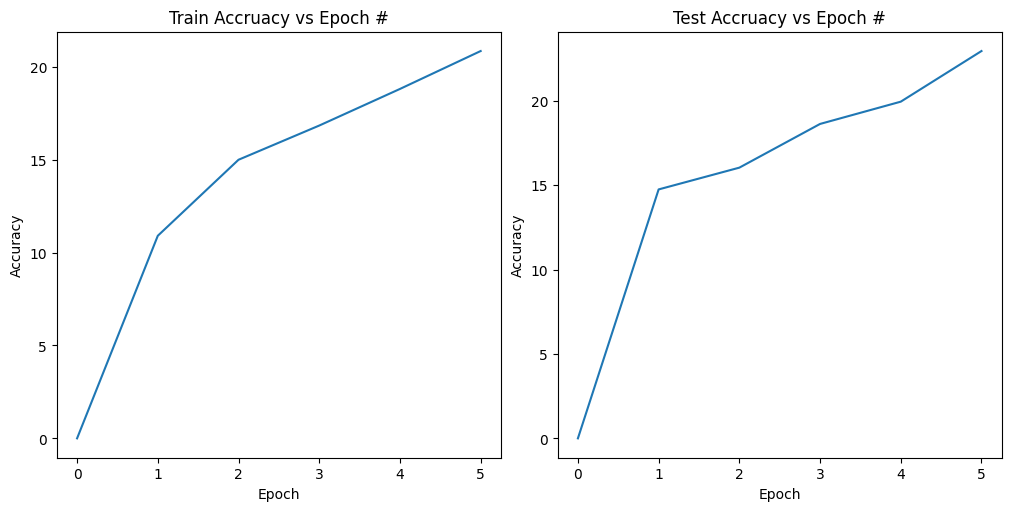

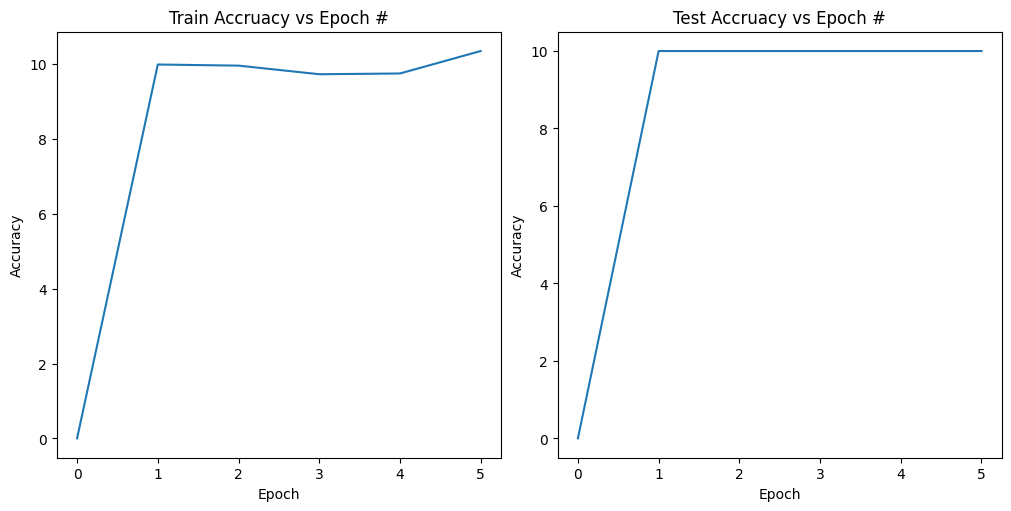

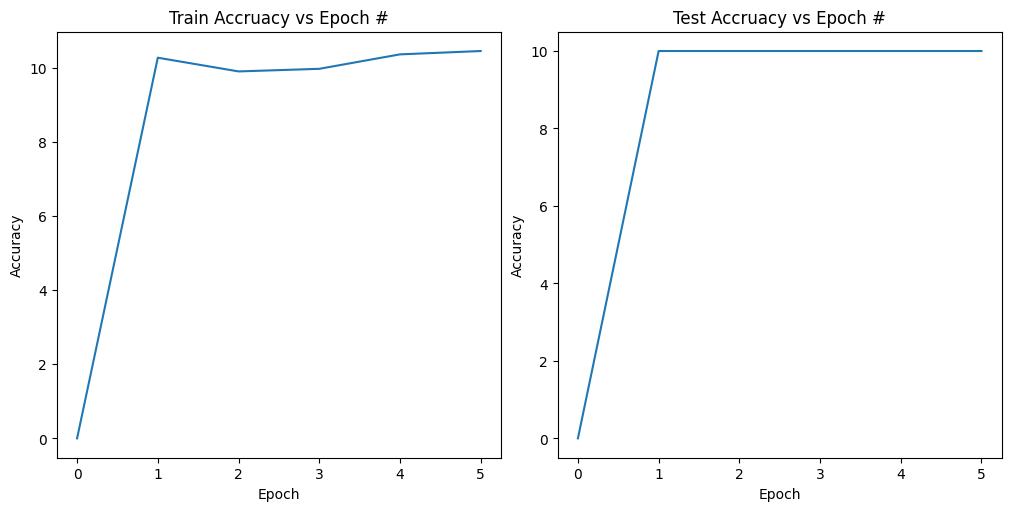

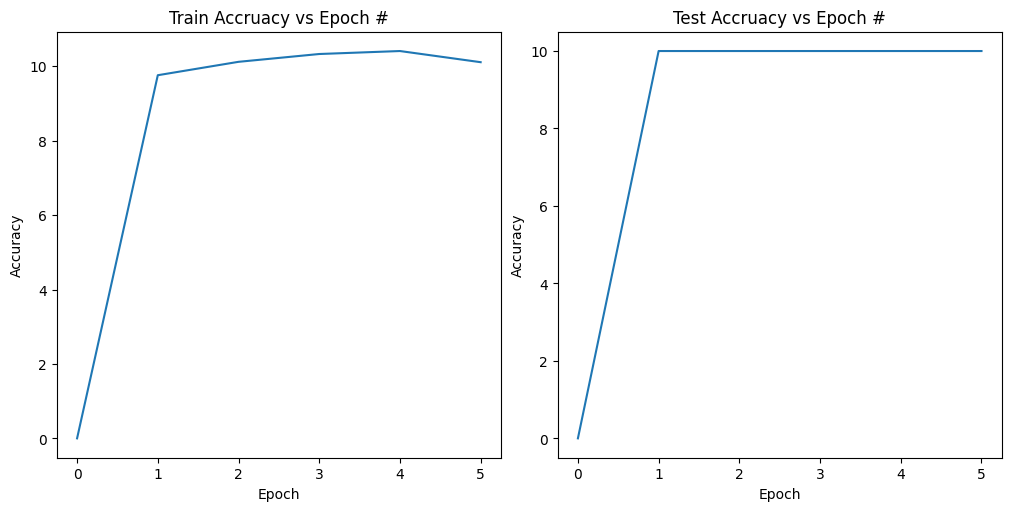

In [19]:
#varying number of layers from 1 to 9
for i in range(1,10):
    mlp = MLP(i,512)
    loss_function = nn.CrossEntropyLoss()
    optimizer_mlp = torch.optim.Adam(mlp.parameters(), lr=0.001)
    print("Training MLP with ", i, " hidden layers")
    train_nn(mlp,optimizer_mlp,loss_function,5)

## Varying Number of Nodes for MLP

Training MLP with  100  # of perceptrons per hidden layer
epoch: 1 train_accuracy 19.6 test_accuracy 23.88
epoch: 2 train_accuracy 26.81 test_accuracy 29.52
epoch: 3 train_accuracy 31.78 test_accuracy 32.91
epoch: 4 train_accuracy 35.18 test_accuracy 34.93
epoch: 5 train_accuracy 37.29 test_accuracy 35.36
Training MLP with  200  # of perceptrons per hidden layer
epoch: 1 train_accuracy 22.57 test_accuracy 27.69
epoch: 2 train_accuracy 32.34 test_accuracy 34.83
epoch: 3 train_accuracy 36.61 test_accuracy 36.33
epoch: 4 train_accuracy 39.35 test_accuracy 36.76
epoch: 5 train_accuracy 41.88 test_accuracy 38.37
Training MLP with  300  # of perceptrons per hidden layer
epoch: 1 train_accuracy 23.66 test_accuracy 31.66
epoch: 2 train_accuracy 34.35 test_accuracy 35.75
epoch: 3 train_accuracy 38.03 test_accuracy 38.12
epoch: 4 train_accuracy 41.77 test_accuracy 38.07
epoch: 5 train_accuracy 44.71 test_accuracy 40.17
Training MLP with  400  # of perceptrons per hidden layer
epoch: 1 train_accu

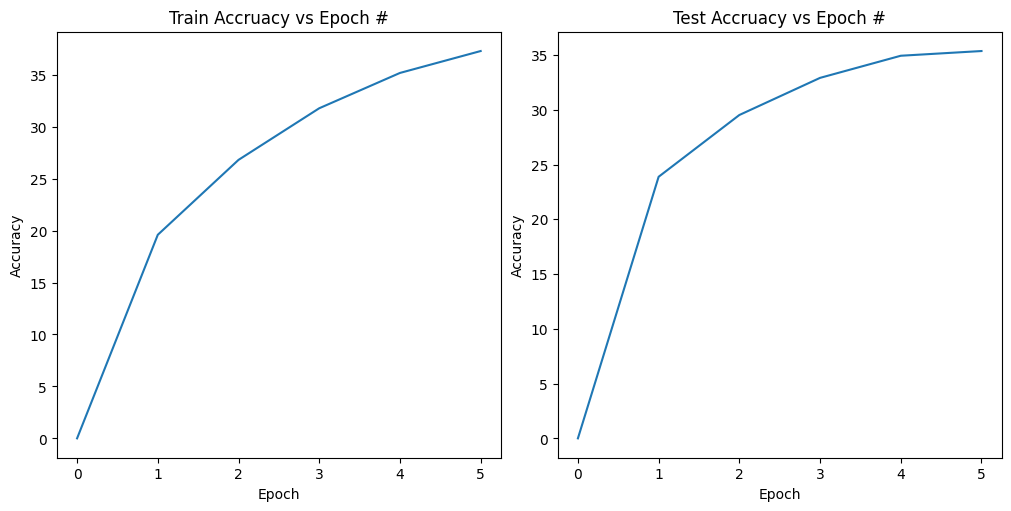

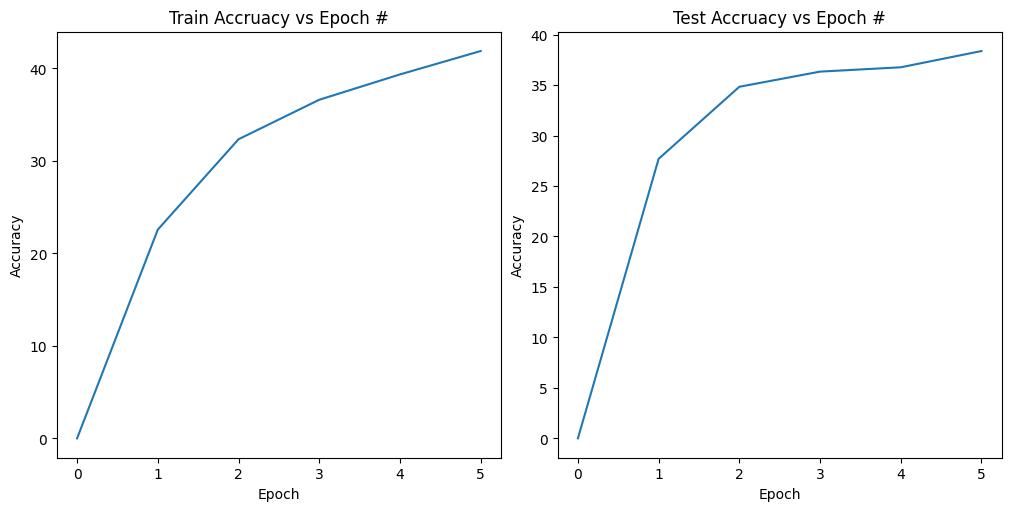

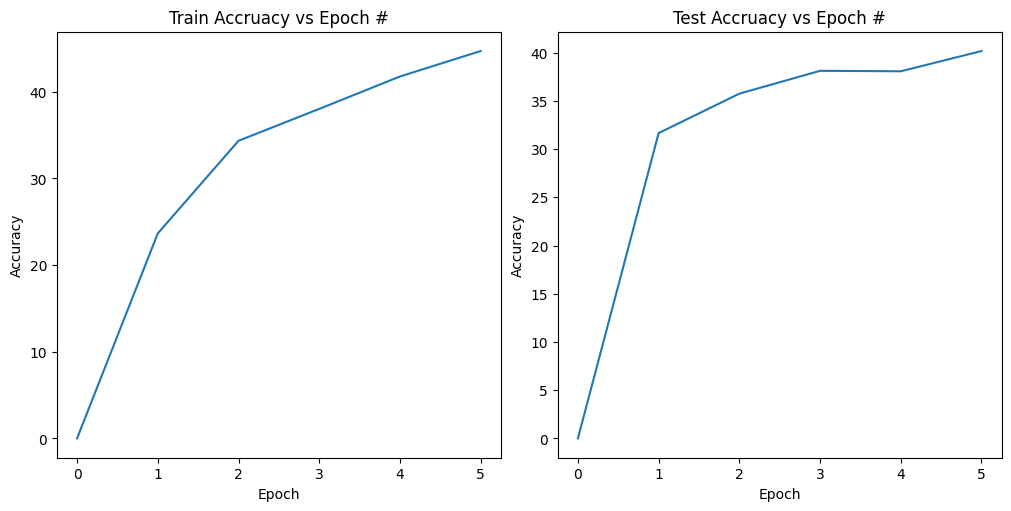

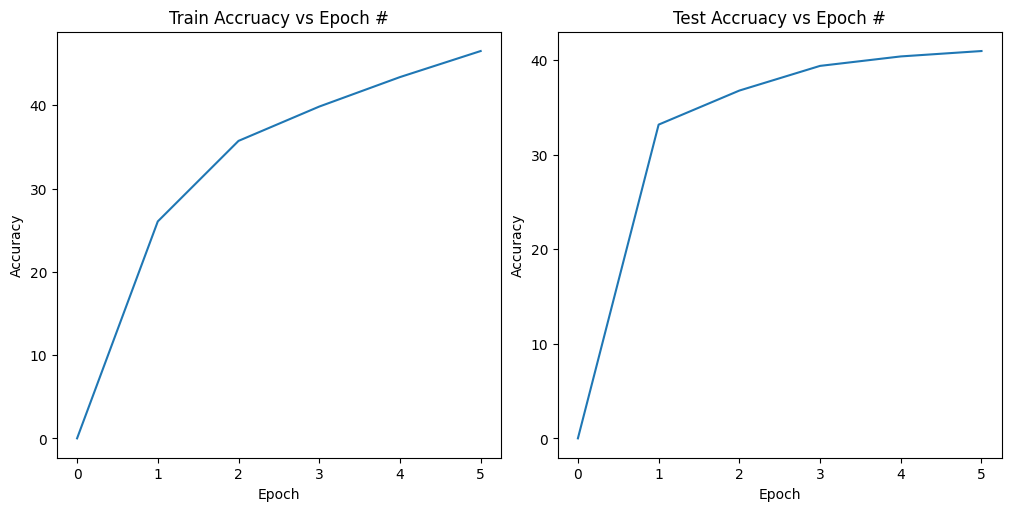

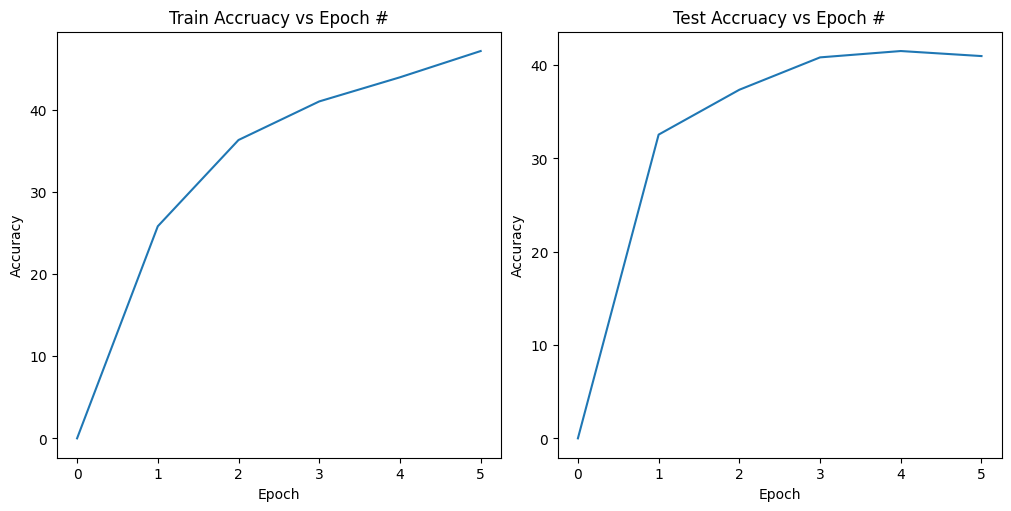

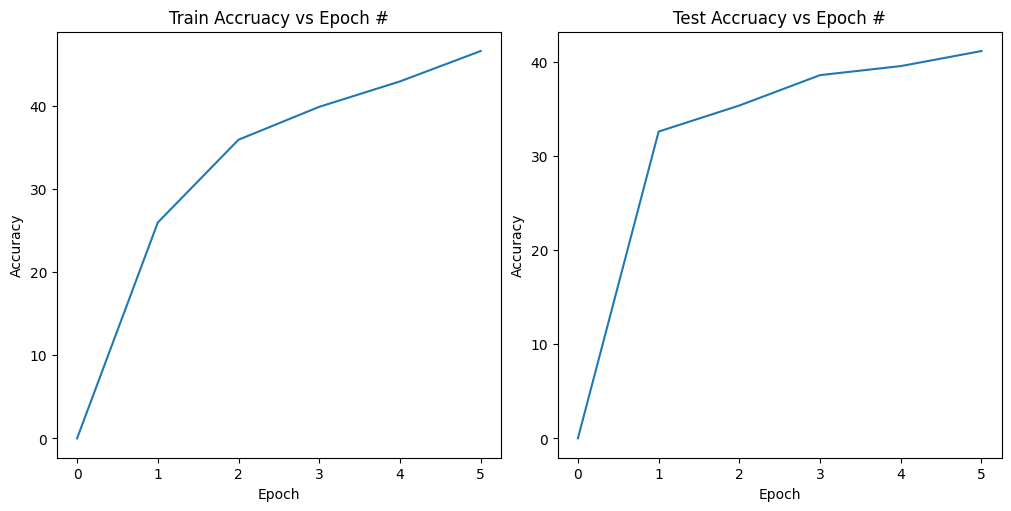

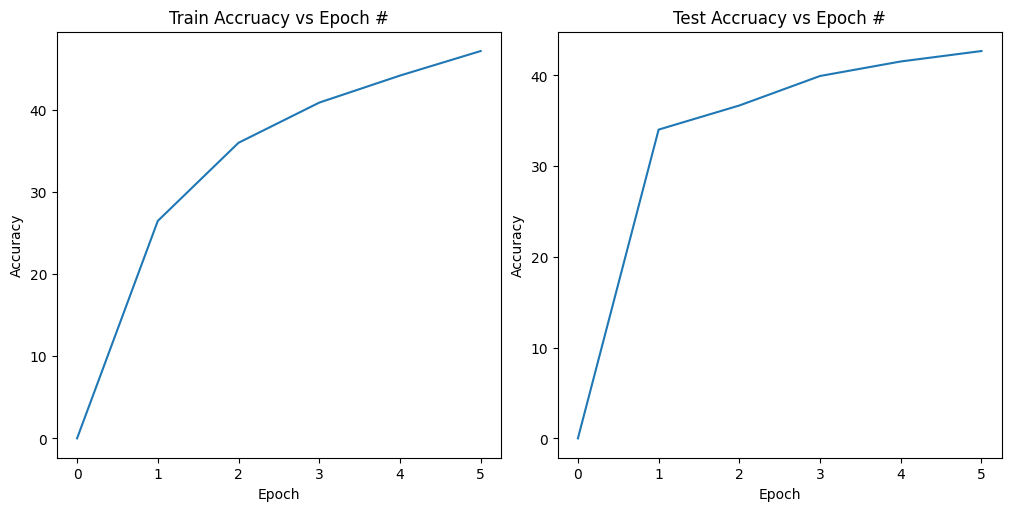

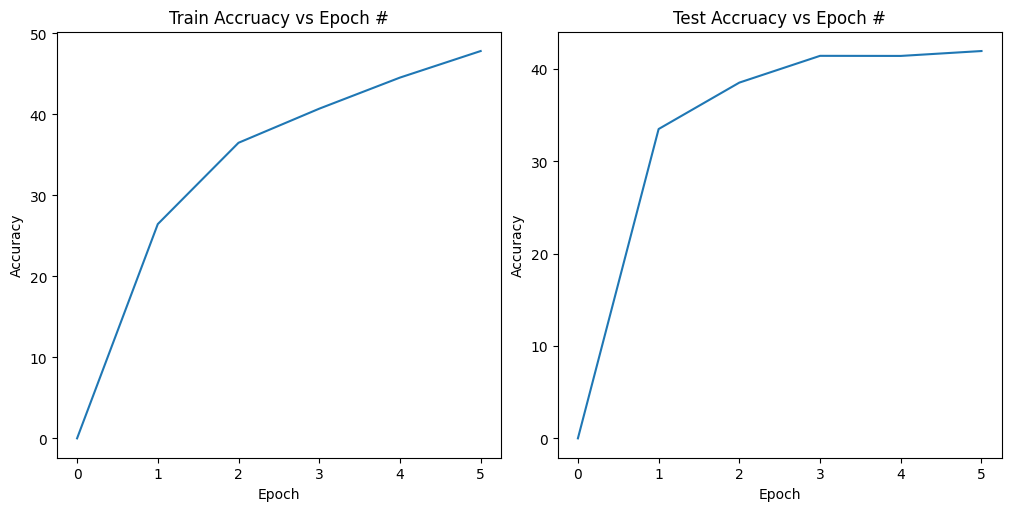

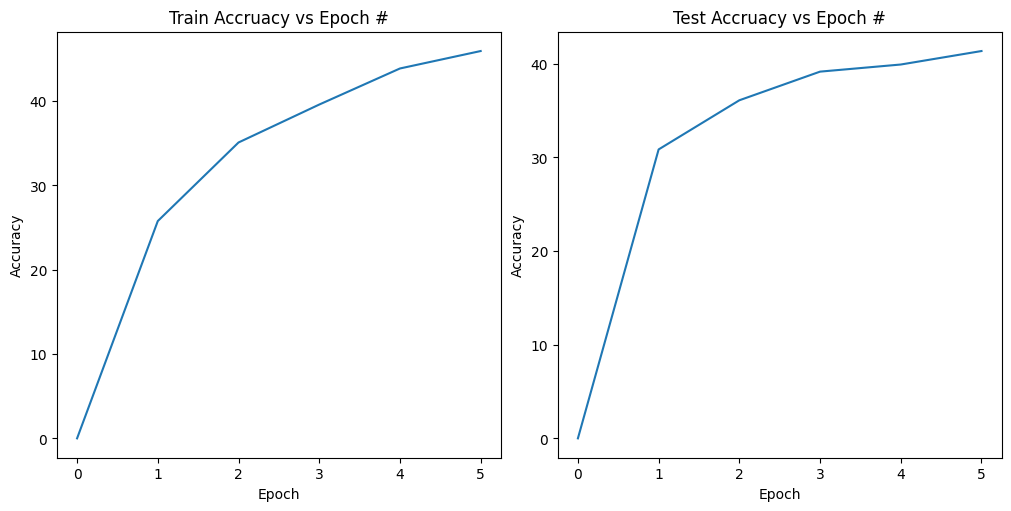

In [20]:
#varying number of neurons from 100 to 900
for i in range (100,1000,100):
    mlp = MLP(2,i)
    loss_function = nn.CrossEntropyLoss()
    optimizer_mlp = torch.optim.Adam(mlp.parameters(), lr=0.001)
    print("Training MLP with ", i, " # of perceptrons per hidden layer")
    train_nn(mlp,optimizer_mlp,loss_function,5)